# Lab-1 - Some Basic Growth Facts

## Purpose

This introductory lab will serve two purposes.  

1. It will acquaint you with some basic growth facts that you will seek to explain later in the semester.  
2. It will allow you to apply your new knowledge of Python and Jupyter notebooks.

# Assignment

In this lab, you will document cross-country differences in income and growth rates to help motivate the study of growth throughout the semester. The final product is a Jupyter notebook that provides and answer to all the questions. It must perform all analyses and create all the figures, and export the outputs requested. 

# Setup -  Import packages and setup paths

Create a `pathout` variable and `pathgraphs` for the name of the directories where you will save data and figures. If they do not exist, make sure to create them

In [3]:
# Let's import pandas, os, numpy, and some other basic packages we will use 
# YOUR CODE HERE
# Basic Packages
from __future__ import division
import os
from datetime import datetime

# Web & file access
import requests
import io

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%pylab --no-import-all
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

import plotly.express as px
import plotly.graph_objects as go

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
# Next line can import all of plotnine, but may overwrite things? Better import each function/object you need
#from plotnine import *

# Data
import pandas as pd
import numpy as np
from pandas_datareader import data, wb

# GIS & maps
import geopandas as gpd
gp = gpd
import georasters as gr
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

# Data Munging
from itertools import product, combinations
import difflib
import pycountry
import geocoder
from geonamescache.mappers import country
mapper = country(from_key='name', to_key='iso3')
mapper2 = country(from_key='iso3', to_key='iso')
mapper3 = country(from_key='iso3', to_key='name')

# Regressions & Stats
from scipy.stats import norm
import statsmodels.formula.api as smf
# from stargazer.stargazer import Stargazer, LineLocation

# Paths
pathout = './data/'

if not os.path.exists(pathout):
    os.mkdir(pathout)
    
pathgraphs = './graphs/'
if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)


Using matplotlib backend: MacOSX
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
assert(os.path.exists(pathout)==True)
assert(os.path.exists(pathgraphs)==True)

# 1. Import Data

Use the code from class to create income per capita data from the Penn World Tables and the World Development Indicators for the 1950-2021 period.

Create a dataframe for each data source that contains the following variables:
1. Country code: `country_code`
2. Country name: `country_name`
2. Year: `year`
3. GDP per capita: `gdp_pc`

For PWT use only `rgdpe` for GDP and name the dataframe `pwt`, for WDi use `'NY.GDP.PCAP.PP.KD'` for GDP per capita and name it `wdi`.

Save the files with names `pwt100.dta` and `wdi.dta` in the `pathout` directory.

## PWT-10

In [5]:
# Download PWT-10 data
pwt_version = '100'
pwt = pd.read_stata('https://www.rug.nl/ggdc/docs/pwt' + pwt_version + '.dta')
pwt_labels = pd.io.stata.StataReader('https://www.rug.nl/ggdc/docs/pwt' + pwt_version + '.dta').variable_labels()
pwt

# Generate GDPpc using rgdpe measure
# YOUR CODE HERE
pwt['gdp_pc'] = pwt['rgdpe'] / pwt['pop']


# Select columns and rename them if necessary
# None


# Save dataframe with 4 requested variables
pwt100 = pwt[['countrycode', 'country', 'year', 'gdp_pc']]
pwt100.to_stata(pathout+'/pwt100.dta')

In [6]:
assert(pwt.shape==(12810,4))
assert(os.path.exists(pathout + '/pwt100.dta')==True)

AssertionError: 

## WDI

Get countries and their regions and basic info useful later, especially for plotting

In [7]:
# YOUR CODE HERE
from pandas_datareader import data, wb
wbcountries = wb.get_countries()
wbcountries = wbcountries.loc[wbcountries.region.isin(['Aggregates'])==False].reset_index(drop=True)
wbcountries['name'] = wbcountries.name.str.strip()
wbcountries['incomeLevel'] = wbcountries['incomeLevel'].str.title()
wbcountries.loc[wbcountries.iso3c=='VEN', 'incomeLevel'] = 'Upper Middle Income'

Download data

In [8]:
# YOUR CODE HERE
wdi_indicators = ['NY.GDP.PCAP.PP.KD', 'NY.GDP.PCAP.KD', 'SL.GDP.PCAP.EM.KD', 'SP.POP.GROW', 'SP.POP.TOTL', 'SP.DYN.WFRT', 'SP.DYN.TFRT.IN']
wdi = wb.download(indicator=wdi_indicators, country=wbcountries.iso2c.values, start=1950, end=2022)
wdi = wdi.reset_index()
wdi['year'] = wdi.year.astype(int)
wdi['gdp_pc'] = wdi['NY.GDP.PCAP.PP.KD']
wdi['ln_gdp_pc'] = wdi['NY.GDP.PCAP.PP.KD'].apply(np.log)
wdi['ln_pop'] = wdi['SP.POP.TOTL'].apply(np.log)
wdi.head()

/Users/chasemoabery/opt/anaconda3/envs/EconGrowthUG-Builds/lib/python3.9/site-packages/pandas_datareader/wb.py:592: UserWarning: Non-standard ISO country codes: JG, XK


,country,year,NY.GDP.PCAP.PP.KD,NY.GDP.PCAP.KD,SL.GDP.PCAP.EM.KD,SP.POP.GROW,SP.POP.TOTL,SP.DYN.WFRT,SP.DYN.TFRT.IN,gdp_pc,ln_gdp_pc,ln_pop
0,Aruba,2021,NaN,NaN,NaN,0.401008,107195.0,NaN,NaN,NaN,NaN,11.582405
1,Aruba,2020,29563.756955,23026.332866,NaN,0.428017,106766.0,NaN,1.901,29563.756955,10.294304,11.578395
2,Aruba,2019,38221.117314,29769.293907,NaN,0.437415,106310.0,NaN,1.901,38221.117314,10.551143,11.574115
3,Aruba,2018,39206.356147,30536.667193,NaN,0.459266,105846.0,NaN,1.896,39206.356147,10.576594,11.569740
4,Aruba,2017,38893.960556,30293.351539,NaN,0.471874,105361.0,NaN,1.886,38893.960556,10.568594,11.565148


Merge WDI datasets so we have codes and names together

In [9]:
# YOUR CODE HERE
wdi = wbcountries.merge(wdi, left_on='name', right_on='country')
wdi.head()

,iso3c,iso2c,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude,...,NY.GDP.PCAP.PP.KD,NY.GDP.PCAP.KD,SL.GDP.PCAP.EM.KD,SP.POP.GROW,SP.POP.TOTL,SP.DYN.WFRT,SP.DYN.TFRT.IN,gdp_pc,ln_gdp_pc,ln_pop
0,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,NaN,NaN,NaN,0.401008,107195.0,NaN,NaN,NaN,NaN,11.582405
1,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,29563.756955,23026.332866,NaN,0.428017,106766.0,NaN,1.901,29563.756955,10.294304,11.578395
2,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,38221.117314,29769.293907,NaN,0.437415,106310.0,NaN,1.901,38221.117314,10.551143,11.574115
3,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,39206.356147,30536.667193,NaN,0.459266,105846.0,NaN,1.896,39206.356147,10.576594,11.569740
4,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,38893.960556,30293.351539,NaN,0.471874,105361.0,NaN,1.886,38893.960556,10.568594,11.565148


Select the 4 requested variables and save file

In [10]:
# YOUR CODE HERE
wdi_final = wdi[['iso3c', 'name', 'year', 'gdp_pc']]
wdi_final.to_stata(pathout+'/wdi.dta')

In [11]:
assert(wdi.shape==(13454,4))
assert(os.path.exists(pathout + '/wdi.dta')==True)
assert((wdi.columns==['country_code', 'country_name', 'year', 'gdp_pc']).all())

AssertionError: 

# 2. Compare Income levels

For each of these two datasets: 

* compute the average level of real per capita income in the earliest and in the latest year across all the countries in each dataset.  
* Find the minimum per capita income in each of these two periods
* Compute the maximum per capita income in each of these two periods
* Compute the ratio of GDP per capita between richest to poorest in the two periods
* Show how the distribution of income has changed over time by  plotting the distributions of log-income per capita in different years using kernel densities. Export each figure as a pdf file into ``pathgraphs`` with name ``dataset_gdppc_year.pdf``. To do this, write a function that takes as inputs the dataset and the year you want to plot.
* Create a figure that compares the distribution of log-income per capita in both years for each dataset, i.e., it shows both jointly in one figure, and export it as a pdf and a png file into ``pathgraphs`` with names ``dataset_gdppc_minyear_maxyear.pdf`` and ``dataset_gdppc_minyear_maxyear.png``.

You need to name the variables in a way that the example code runs. 

Save the earliest year in PWT as `year_min_pwt`.

In [12]:
# YOUR CODE HERE
year_min_pwt = pwt100['year'].min()

In [13]:
print("Earliest year in PWT is ", year_min_pwt, '\n')

Earliest year in PWT is  1950 



Earliest year in WDI as `year_min_wdi`

In [14]:
# YOUR CODE HERE
year_min_wdi = wdi_final['year'].min()

In [15]:
print("Earliest year in WDI is ", year_min_wdi, '\n')

Earliest year in WDI is  1960 



Latest year in PWT as `year_max_pwt`

In [16]:
# YOUR CODE HERE
year_max_pwt = pwt100['year'].max()

In [17]:
print("Latest year in PWT is ", year_max_pwt, '\n')

Latest year in PWT is  2019 



Latest year in WDI as `year_max_wdi`

In [18]:
# YOUR CODE HERE
year_max_wdi = wdi_final['year'].max()

In [19]:
print("Latest year in WDI is ", year_max_wdi, '\n')

Latest year in WDI is  2021 



Average GDP pc in earliest year in PWT as `mean_gdppc_pwt_early`

In [20]:
# YOUR CODE HERE
mean_gdppc_pwt_early = pwt100['gdp_pc'].mean()

In [21]:
print("The average income per capita in the earliest year, i.e.,", year_min_pwt, "in the PWT, is ", mean_gdppc_pwt_early, '\n')

The average income per capita in the earliest year, i.e., 1950 in the PWT, is  13261.811887716554 



Average GDP pc in earliest year in WDI as `mean_gdppc_wdi_early`

In [22]:
# YOUR CODE HERE
mean_gdppc_wdi_early = wdi_final['gdp_pc'].mean()

In [23]:
print("The average income per capita in the earliest year, i.e.,", year_min_wdi, "in the WDI, is ", mean_gdppc_wdi_early, '\n')

The average income per capita in the earliest year, i.e., 1960 in the WDI, is  18148.5782953583 



Average GDP pc in latest year in PWT as `mean_gdppc_pwt_late`

In [24]:
# YOUR CODE HERE
mean_gdppc_pwt_late_df = pwt100.loc[pwt100['year'] == year_max_pwt]
mean_gdppc_pwt_late = mean_gdppc_pwt_late_df['gdp_pc'].mean()

In [25]:
print("The average income per capita in the latest year, i.e.,", year_max_pwt, "in the PWT, is ", mean_gdppc_pwt_late, '\n')

The average income per capita in the latest year, i.e., 2019 in the PWT, is  23037.87664770433 



Average GDP pc in latest year in WDI as `mean_gdppc_wdi_late`

In [26]:
# YOUR CODE HERE
mean_gdppc_wdi_late_df = wdi_final.loc[wdi_final['year'] == year_max_wdi]
mean_gdppc_wdi_late = mean_gdppc_wdi_late_df['gdp_pc'].mean()

In [27]:
print("The average income per capita in the latest year, i.e.,", year_max_wdi, "in the WDI, is ", mean_gdppc_wdi_late, '\n')

The average income per capita in the latest year, i.e., 2021 in the WDI, is  20809.950184579895 



Minimum GDP pc in earliest year in PWT as `min_gdppc_pwt_early`

In [28]:
# YOUR CODE HERE
min_gdppc_pwt_early_df = pwt100.loc[pwt100['year'] == year_min_pwt]
min_gdppc_pwt_early = min_gdppc_pwt_early_df['gdp_pc'].min()

In [29]:
print("The minimum income per capita in the earliest year, i.e.,", year_min_pwt, "in the PWT, is ", min_gdppc_pwt_early, '\n')

The minimum income per capita in the earliest year, i.e., 1950 in the PWT, is  404.2977198866964 



Minimum GDP pc in earliest year in WDI as `min_gdppc_wdi_early`

In [30]:
# YOUR CODE HERE
min_gdppc_wdi_early_df = wdi_final.loc[wdi_final['year'] == year_min_wdi]
min_gdppc_wdi_early = min_gdppc_wdi_early_df['gdp_pc'].min()

In [31]:
print("The minimum income per capita in the earliest year, i.e.,", year_min_wdi, "in the WDI, is ", min_gdppc_wdi_early, '\n')

The minimum income per capita in the earliest year, i.e., 1960 in the WDI, is  nan 



Minimum GDP pc in latest year in PWT as `min_gdppc_pwt_late`

In [32]:
# YOUR CODE HERE
min_gdppc_pwt_late_df = pwt100.loc[pwt100['year'] == year_max_pwt]
min_gdppc_pwt_late = min_gdppc_pwt_late_df['gdp_pc'].min()

In [33]:
print("The minimum income per capita in the latest year, i.e.,", year_max_pwt, "in the PWT, is ", min_gdppc_pwt_late, '\n')

The minimum income per capita in the latest year, i.e., 2019 in the PWT, is  251.31907535789156 



Minimum GDP pc in latest year in WDI as `min_gdppc_wdi_late`

In [34]:
# YOUR CODE HERE
min_gdppc_wdi_late_df = wdi_final.loc[wdi_final['year'] == year_max_wdi]
min_gdppc_wdi_late = min_gdppc_wdi_late_df['gdp_pc'].min()

In [35]:
print("The minimum income per capita in the latest year, i.e.,", year_max_wdi, "in the WDI, is ", min_gdppc_wdi_late, '\n')

The minimum income per capita in the latest year, i.e., 2021 in the WDI, is  722.046273490697 



Maximum GDP pc in earliest year in PWT as `max_gdppc_pwt_early`

In [36]:
# YOUR CODE HERE
max_gdppc_pwt_early_df = pwt100.loc[pwt100['year'] == year_min_pwt]
max_gdppc_pwt_early = max_gdppc_pwt_early_df['gdp_pc'].max()

In [37]:
print("The maximum income per capita in the earliest year, i.e.,", year_min_pwt, "in the PWT, is ", max_gdppc_pwt_early, '\n')

The maximum income per capita in the earliest year, i.e., 1950 in the PWT, is  15781.567100992643 



Maximum GDP pc in earliest year in WDI as `max_gdppc_wdi_early`

In [38]:
# YOUR CODE HERE
max_gdppc_wdi_early_df = wdi_final.loc[wdi_final['year'] == year_min_wdi]
max_gdppc_wdi_early = max_gdppc_wdi_early_df['gdp_pc'].max()

In [39]:
print("The maximum income per capita in the earliest year, i.e.,", year_min_wdi, "in the WDI, is ", max_gdppc_wdi_early, '\n')

The maximum income per capita in the earliest year, i.e., 1960 in the WDI, is  nan 



Maximum GDP pc in latest year in PWT as `max_gdppc_pwt_late`

In [40]:
# YOUR CODE HERE
max_gdppc_pwt_late_df = pwt100.loc[pwt100['year'] == year_max_pwt]
max_gdppc_pwt_late = max_gdppc_pwt_late_df['gdp_pc'].max()

In [41]:
print("The maximum income per capita in the latest year, i.e.,", year_max_pwt, "in the PWT, is ", max_gdppc_pwt_late, '\n')

The maximum income per capita in the latest year, i.e., 2019 in the PWT, is  112941.45334229832 



Maximum GDP pc in latest year in WDI as `max_gdppc_wdi_late`

In [42]:
# YOUR CODE HERE
max_gdppc_wdi_late_df = wdi_final.loc[wdi_final['year'] == year_max_wdi]
max_gdppc_wdi_late = max_gdppc_wdi_late_df['gdp_pc'].min()

In [43]:
print("The maximum income per capita in the latest year, i.e.,", year_max_wdi, "in the WDI, is ", max_gdppc_wdi_late, '\n')

The maximum income per capita in the latest year, i.e., 2021 in the WDI, is  722.046273490697 



Ratio of GDP pc in earliest year in PWT as `ratio_gdppc_pwt_early`

In [52]:
# YOUR CODE HERE
ratio_gdppc_pwt_early = pwt100.loc[pwt100['year'] == year_min_wdi]['gdp_pc'].mean()

In [53]:
print("The ratio income per capita in the earliest year, i.e.,", year_min_pwt, "in the PWT, is ", ratio_gdppc_pwt_early, '\n')

The ratio income per capita in the earliest year, i.e., 1950 in the PWT, is  4675.059080695825 



Ratio of GDP pc in earliest year in WDI as `ratio_gdppc_wdi_early`

In [58]:
# YOUR CODE HERE
ratio_gdppc_wdi_early = wdi_final.loc[wdi_final['year'] == year_min_wdi]['gdp_pc'].mean()

In [59]:
print("The ratio income per capita in the earliest year, i.e.,", year_min_wdi, "in the WDI, is ", ratio_gdppc_wdi_early, '\n')

The ratio income per capita in the earliest year, i.e., 1960 in the WDI, is  nan 



Ratio of GDP pc in latest year in PWT as `ratio_gdppc_pwt_late`

In [54]:
# YOUR CODE HERE
ratio_gdppc_pwt_late = pwt100.loc[pwt100['year'] == year_max_wdi]['gdp_pc'].mean()

In [60]:
print("The ratio income per capita in the latest year, i.e.,", year_max_pwt, "in the PWT, is ", ratio_gdppc_pwt_late, '\n')

The ratio income per capita in the latest year, i.e., 2019 in the PWT, is  nan 



Ratio of GDP pc in latest year in WDI as `ratio_gdppc_wdi_late`

In [61]:
# YOUR CODE HERE
ratio_gdppc_wdi_late = wdi_final.loc[wdi_final['year'] == year_max_wdi]['gdp_pc'].mean()

In [62]:
print("The ratio income per capita in the latest year, i.e.,", year_max_wdi, "in the WDI, is ", ratio_gdppc_wdi_late, '\n')

The ratio income per capita in the latest year, i.e., 2021 in the WDI, is  20809.950184579895 



In [63]:
assert(year_min_pwt==1950)
assert(year_max_pwt==2019)


Let's now create the function to plot each distribution in each year and dataset

In [64]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.reset_orig()
sns.set_context("talk")

def my_kde_plots(dataset='pwt', myyear=year_min_pwt):
    '''
    This function plots the KDE-plot of log income per capita, where
    
    dataset: is either pwt or wdi (one of the two datasets you created above)
    myyear: is one of the year variables you created above, e.g., year_min_pwt, year_min_wdi
    '''
    df = pwt100
    if dataset != 'pwt':
        df = wdi_final
    df.loc[df['year'] == myyear].plot.kde()

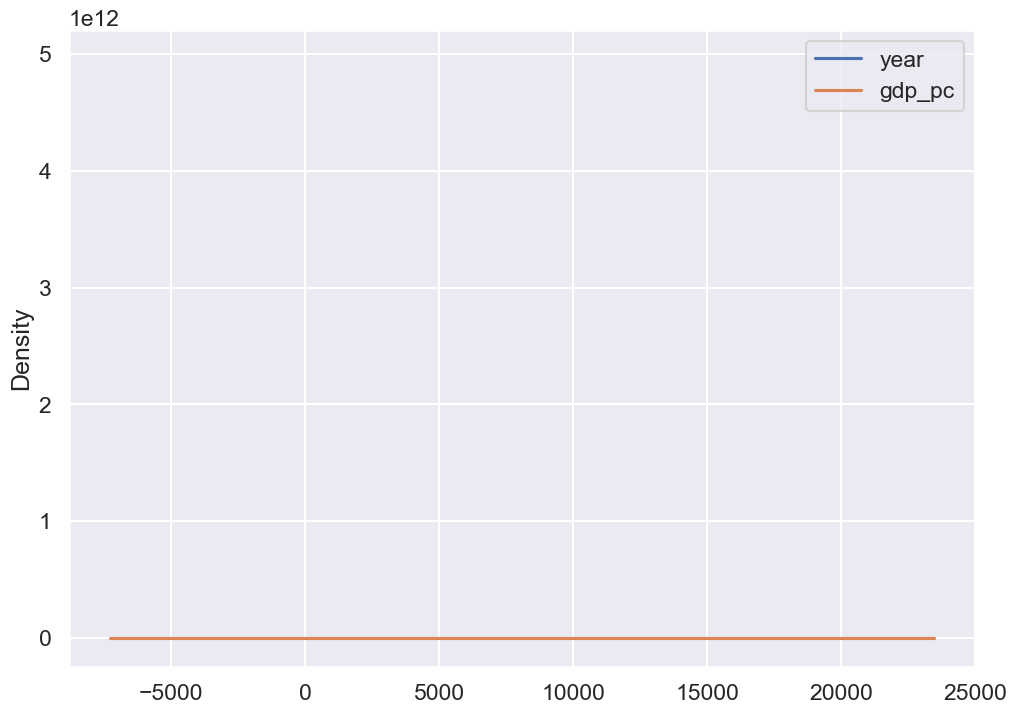

In [66]:
# KDE plot for PWT in earliest period
my_kde_plots()

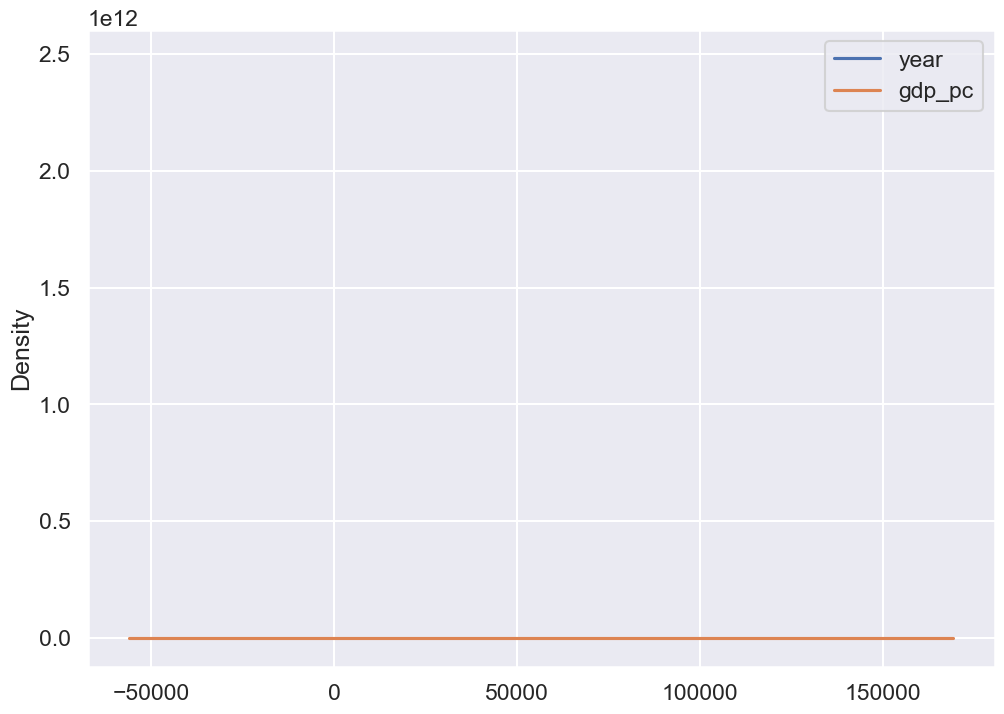

In [67]:
# KDE plot for PWT in latest period
my_kde_plots(myyear=year_max_pwt)

LinAlgError: singular matrix

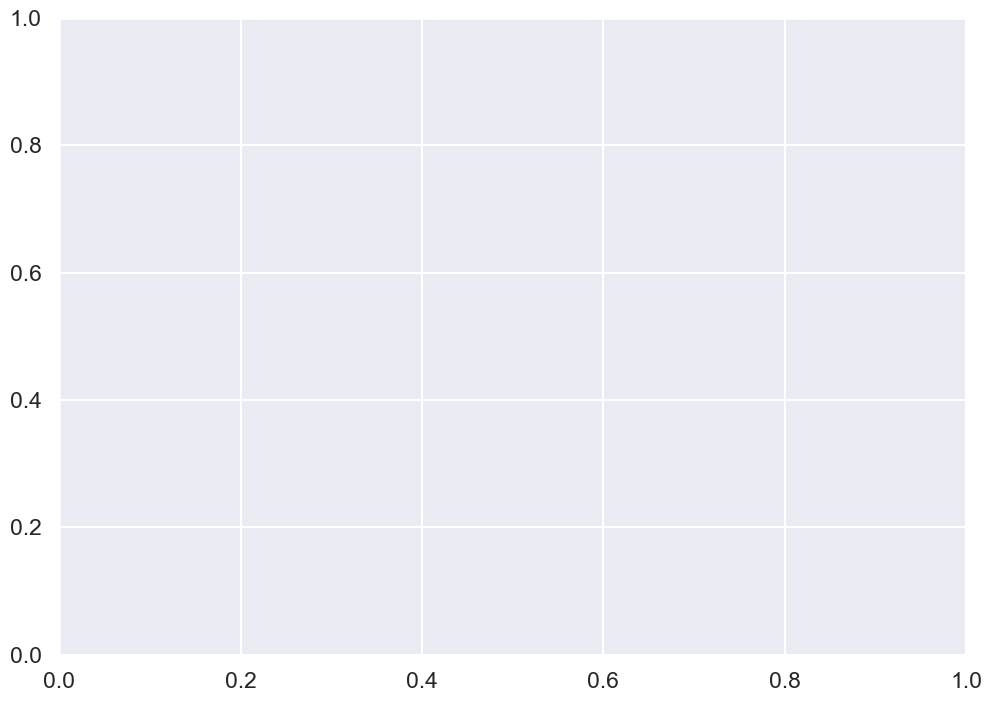

In [68]:
# KDE plot for WDI in earliest period
my_kde_plots(dataset='wdi', myyear=year_min_wdi)

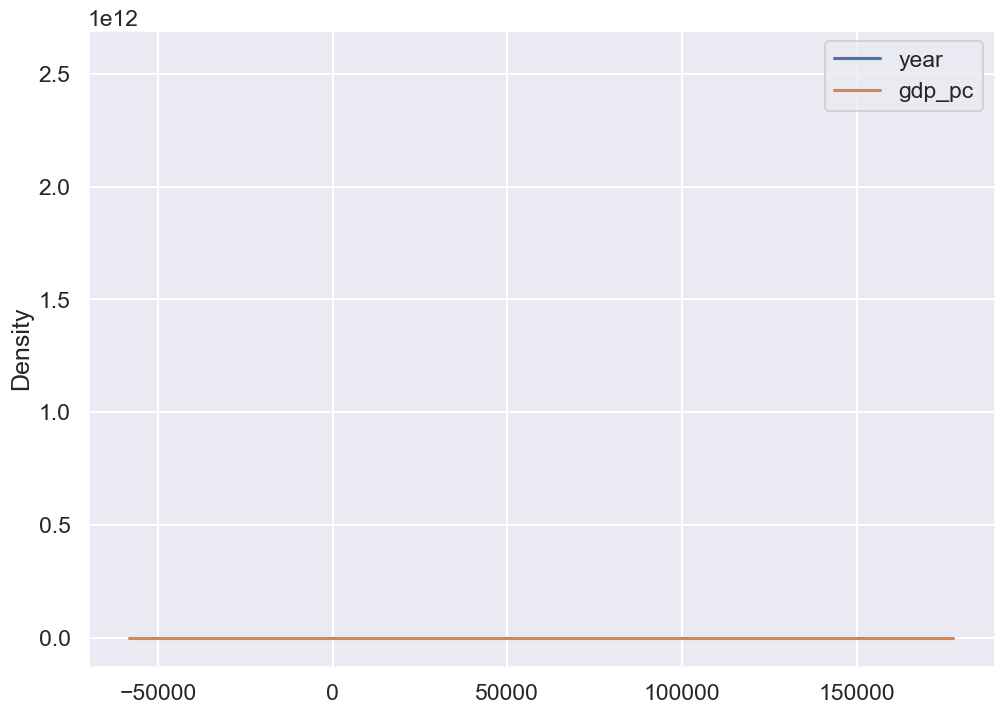

In [69]:
# KDE plot for PWT in latest period
my_kde_plots(dataset='wdi', myyear=year_max_wdi)

In [71]:
assert(os.path.exists(pathgraphs + '/pwt_gdppc_' + str(year_min_pwt) + '.pdf')==True)
assert(os.path.exists(pathgraphs + '/wdi_gdppc_' + str(year_min_wdi) + '.pdf')==True)

AssertionError: 

Let's write a function that plots for each dataset and pair of years the distributions in that year and exports it to both png and pdf.

In [72]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.reset_orig()
sns.set_context("talk")

def my_kde_plots_joint(dataset='pwt', myyears=[year_min_pwt, year_max_pwt], myvar='gdp_pc', myvar_label='Income per capita'):
    '''
    This function plots the KDE-plot of log income per capita in two years, where
    
    dataset: is either pwt or wdi (one of the two datasets you created above)
    myyears: is a list of years
    '''
    df = eval(dataset + '.loc[' + dataset +'.year.isin(myyears)].copy().reset_index(drop=True)')
    # Plot
    mycolors = sns.color_palette("Paired",n_colors=len(myyears))
    fig, ax = plt.subplots()
    for t in range(len(myyears)):
        sns.kdeplot(df.loc[df.year==myyears[t], myvar], ax=ax, shade=True, label=str(myyears[t]), linewidth=2, color=mycolors[t])
    ax.set_xlabel(myvar_label)
    ax.set_ylabel('Density of Countries')
    ax.legend()
    plt.savefig(pathgraphs + dataset +'_' + myvar + '_' + str(myyears[0]) + '_' + str(myyears[-1]) + '.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(pathgraphs + dataset +'_' + myvar + '_' + str(myyears[0]) + '_' + str(myyears[-1]) + '.png', dpi=300, bbox_inches='tight')
    plt.draw()
    return "Done"

'Done'

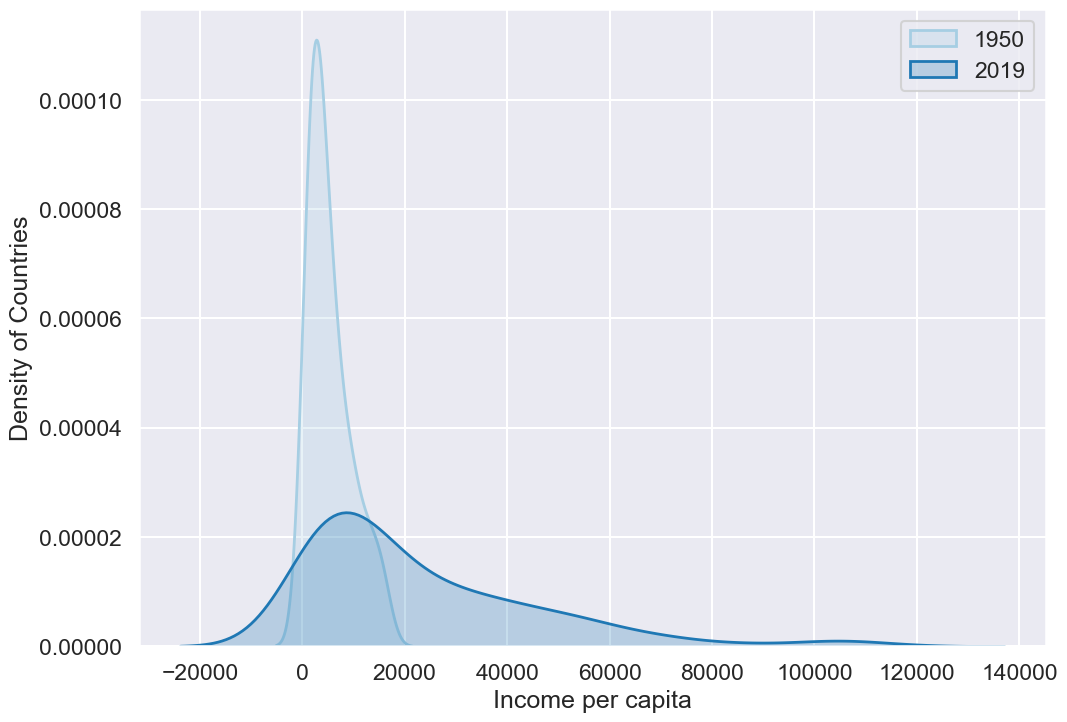

In [75]:
# Plot PWT
my_kde_plots_joint()

'Done'

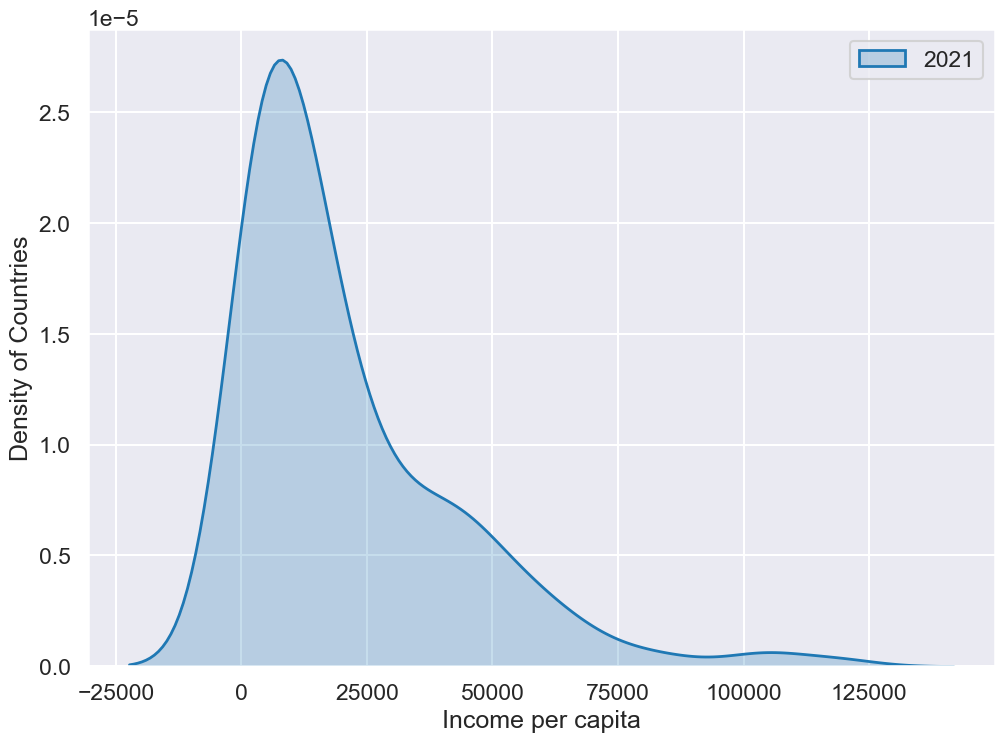

In [74]:
# Plot WDI
my_kde_plots_joint(dataset='wdi', myyears=[year_min_wdi, year_max_wdi])

In [77]:
assert(os.path.exists(pathgraphs + 'pwt_gdppc_' + str(year_min_pwt) + '_' + str(year_max_pwt) + '.pdf')==True)
assert(os.path.exists(pathgraphs + 'wdi_gdppc_' + str(year_min_wdi) + '_' + str(year_max_wdi) + '.pdf')==True)

AssertionError: 

# 3. Growth rates

Compute the growth rate of real per capita income over the time period between the first year and the last year as

$$
growth = \log(gdp\_pc_{last}) - \log(gdp\_pc_{first})
$$

Save the results in a new dataframe called `growth_dataset`.  What is the average growth rate for all the countries in your data? Save it as `mean_growth_dataset`. What is the minimum growth rate? Save it as `min_growth_dataset`. What is the maximum growth rate? Save it as `max_growth_dataset`.

Compute growth rates

In [145]:
# YOUR CODE HERE
wdi_final.head()
# growth_dataset = wdi_final[['iso3c', 'name', 'year', 'gdp_pc']]
growth_dataset = wdi_final['name']
growth_dataset = growth_dataset.drop_duplicates()
growth_dataset.reset_index(drop=True)

# pwt100.loc[pwt100['year'] == year_max_wdi]['gdp_pc'].mean()
growth_list = []
for i in wdi_final['name']:
#     growth_list.append()
    print(i)
#     print(wdi_final.iloc[wdi_final['year'] == year_min_wdi])
#     print(wdi_final.index[(wdi_final['name']==i) & (wdi_final['year']=='year_min_wdi')].to_list())
#     print(year_max_wdi)
#     print(wdi_final.at(wdi_final.index[(wdi_final['name']==i) & (wdi_final['year']==year_max_wdi)], 'gdp_pc'))
    break

print(wdi_final.at[0, 'gdp_pc'])
print(wdi_final.index[wdi_final['name']=='Aruba' & wdi_final['year']==year_max_wdi].to_list())
# growth_dataset['growth_rate']

Aruba
nan


TypeError: Cannot perform 'rand_' with a dtyped [int64] array and scalar of type [bool]

In [98]:
growth_dataset

0               Aruba
62        Afghanistan
124            Angola
186           Albania
248           Andorra
             ...     
13144          Kosovo
13206     Yemen, Rep.
13268    South Africa
13330          Zambia
13392        Zimbabwe
Name: name, Length: 217, dtype: object

Compute Average growth rate

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('Average growth rate between', year_min_pwt, 'and', year_max_pwt, 'according to PWT was {0:.2%}'.format(mean_growth_pwt))
print('Average growth rate between', year_min_wdi, 'and', year_max_wdi, 'according to WDI was {0:.2%}'.format(mean_growth_wdi))


Compute minimum growth rate

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Compute maximum growth rate

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('Maximum growth rate between', year_min_pwt, 'and', year_max_pwt, 'according to PWT was {0:.2%}'.format(max_growth_pwt))
print('Maximum growth rate between', year_min_wdi, 'and', year_max_wdi, 'according to WDI was {0:.2%}'.format(max_growth_wdi))


# 4. Growth rates by WB region

Consider the regions defined by the World Bank: East Asia & Pacific, Europe & Central Asia, Latin America & Caribbean, Middle East & North Africa, North America, South Asia, and Sub-Saharan Africa.  Compute the minimum, maximum, and mean growth rates of income per capita for countries in each of these groups in the earliest and latest year in each dataset.  What patterns can you identify in the growth of income and in the dispersion of income in these regions?

Start by merging the `wbcountries` dataframe with the others to get the regional variable. Create new dataframes `growth_dataset_regions`. 

**Note:** There are 2 countries in PWT that do not appear in the `wbcountries` dataframe. 
They both belong to Latin America & Caribbean (codes: `AIA`, `MSR`). So, they will be dropped in the `joint` merge.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert(growth_wdi.shape[0]==growth_wdi_regions.shape[0])
assert((growth_pwt.shape[0] - 2)==growth_pwt_regions.shape[0])

Compute the statistics by region and save them in a new dataframe `statistic_growth_dataset_regions` that has 1 column with the regions and another with the growth rates.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# 5. Counter-factual Analysis

Using the PWT, take the maximum growth rate that you computed in question 3 and apply it to the poorest country in the earliest date.  Then take the minimum growth rate that you computed in question 3 and apply it to the richest country in the earliest date.  How would these different growth rates affect the level of income in these countries in the last period?  Explain how this computation demonstrates the importance of the study of long-run growth.

Compute counter factual income per capita for the poorest country. Safe value in `poor_counter_factual`.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Compute counter factual income per capita for the richest country. Safe value in `rich_counter_factual`.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert(rich_counter_factual<poor_counter_factual)

# 6. Who's who in economic growth?

Sort the data by the growth rates you computed in number 3.  Identify the 10 fastest growing and the 10 slowest growing countries.  Do the fast growers have anything in common?  Do the slow growers?  Do these lists suggest potential ideas for investigation of the determinants of growth?

Let's sort and show the top 10 slowest growing countries in PWT

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Now in WDI

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Let's sort and show the top 10 fastest growing countries in PWT

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Now in WDI

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# 7. Convergence

Generate a `plotly` scatter plot that shows the income level in the earliest period on the horizontal axis and the growth rate between earliest and latest in the vertical axis. Make sure hovering on a symbols shows the information of the country. Use colors for WB regions and shapes for WB income groups. Export it to file `dataset_convergence_early_late.pdf`. Do you see anything noteworthy?

Start by creating a dataframe with only data for the earliest date `dataset_early` and then merge it with the growth rates dataframe `growth_dataset` (make sure to add a suffix to distinguish variables if needed). Drop any NA's to simplify plotting.

First PWT

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Now WDI

In [ ]:
wdi_early = wdi.loc[wdi.year==year_min_wdi].reset_index(drop=True).copy()
wdi_early = wdi_early.merge(growth_wdi, on=['country_code', 'country_name'], suffixes=['', '_growth'])
wdi_early = wdi_early.merge(wbcountries[['iso3c', 'region', 'incomeLevel']], left_on='country_code', right_on='iso3c')
wdi_early = wdi_early.dropna().reset_index(drop=True)
wdi_early

Now let's plot this data for PWT

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert(os.path.exists(pathgraphs + 'pwt_convergence_' + str(year_min_pwt) + '_' + str(year_max_pwt) + '.pdf'))

Now for WDI

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert(os.path.exists(pathgraphs + 'wdi_convergence_' + str(year_min_wdi) + '_' + str(year_max_wdi) + '.pdf'))

# 8. Persistence

Generate a `plotly` scatter plot that shows the income level in the earliest period on the horizontal axis and the income level in the latest in the vertical axis. Make sure hovering on a symbols shows the information of the country. Use colors for WB regions and shapes for WB income groups. Export it to file `dataset_persistence_early_late.pdf`. Do you see anything noteworthy?

Start by creating a dataframe with only data for the latest date `dataset_late` and then merge it with the `dataset_early` dataframe you cerated in teh previous point (make sure to add a suffix to distinguish variables if needed). Drop any NA's to simplify plotting.

Start with PWT

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Now WDI

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Now let's plot this data for PWT

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert(os.path.exists(pathgraphs + 'pwt_persistence_' + str(year_min_pwt) + '_' + str(year_max_pwt) + '.pdf'))

Now WDI

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert(os.path.exists(pathgraphs + 'wdi_persistence_' + str(year_min_pwt) + '_' + str(year_max_pwt) + '.pdf'))